In [35]:
%matplotlib inline
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import seaborn as sns

sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)

In [1]:
import pandas as pd # pandas是python的数据格式处理类库

# 加载泰坦尼克号生存预测数据集
data_train = pd.read_csv("./data/titanic/train.csv")

In [6]:
def set_missing_ages(p_df):
    """处理数据缺失"""
    p_df.loc[(p_df.Age.isnull()), 'Age'] = p_df.Age.dropna().mean()
    return p_df
df = set_missing_ages(data_train)

# 归一化
import sklearn.preprocessing as preprocessing

scaler = preprocessing.StandardScaler()
df['Age_scaled'] = scaler.fit_transform(data_train['Age'].values.reshape(-1, 1))
df['Fare_scaled'] = scaler.fit_transform(data_train['Fare'].values.reshape(-1, 1))


# 处理类别意义的特征
def set_cabin_type(p_df):
    p_df.loc[(p_df.Cabin.notnull()), 'Cabin'] = "Yes"
    p_df.loc[(p_df.Cabin.isnull()), 'Cabin'] = "No"
    return p_df
df = set_cabin_type(df)

dummies_pclass = pd.get_dummies(data_train['Pclass'], prefix='Pclass')
dummies_embarked = pd.get_dummies(data_train['Embarked'], prefix='Embarked')
dummies_sex = pd.get_dummies(data_train['Sex'], prefix='Sex')
df = pd.concat([df, dummies_embarked, dummies_sex, dummies_pclass], axis=1)

# noinspection PyUnresolvedReferences
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
# 选择哪些特征作为训练特征
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')

from abupy import AbuML

train_np = train_df.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]
titanic = AbuML(x, y, train_df)

titanic.estimator.logistic_classifier()
titanic.cross_val_accuracy_score()

LogisticRegression score mean: 0.79919731018


array([ 0.7778,  0.7889,  0.7753,  0.8202,  0.7865,  0.7753,  0.7865,
        0.7978,  0.8315,  0.8523])

In [11]:
# 构造非线性特征

# 划分区间
df['Child'] = (data_train['Age'] <= 10).astype(int)
# 平方
df['Age*Age'] = data_train['Age'] * data_train['Age']
# 归一化
df['Age*Age_scaled'] = scaler.fit_transform(df['Age*Age'])

# filter加入新增的特征
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*|Child|Age\*Class_.*')
df['Age*Class'] = data_train['Age'] * data_train['Pclass']
# 归一化
df['Age*Class_scaled'] = scaler.fit_transform(df['Age*Class'].values.reshape(-1, 1))

train_np = train_df.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]
titanic = AbuML(x, y, train_df)

titanic.estimator.logistic_classifier()
titanic.cross_val_accuracy_score()

# 评估特征作用
# titanic.importances_coef_pd()
# titanic.feature_selection()

LogisticRegression score mean: 0.805888378164


array([ 0.7889,  0.8   ,  0.7865,  0.8427,  0.809 ,  0.7753,  0.7978,
        0.7865,  0.8427,  0.8295])

In [13]:
# 调试模型

# L2正则化
# X是训练样本矩阵，W是权重矩阵，b是偏置向量，y是真实标签矩阵
def loss_func(X, W, b, y):
    # lmd 是一个可调节的模型参数
    C = 2
    s = score(X, W, b)
    p = softmax(s)
    return -np.mean(cross_entropy(y, p)) + np.mean(np.dot(w.T, w) / C)

from abupy import AbuML

# create_test_more_fiter用于快速测试API，封装了titanic数据集合相关的特征处理
titanic = AbuML.create_test_more_fiter()
titanic.estimator.logistic_classifier()

# 学习曲线
# titanic.plot_learning_curve()


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

In [17]:
# Titanic处理好的数据集
# titanic = AbuML.create_test_more_fiter()

# 使用逻辑分类
# titanic.estimator.logistic_classifier()

# 定义参数搜索范围
# _, best_params = ABuMLGrid.grid_search_init_kwargs(titanic.estimator.clf, titanic.x, titanic.y,
#                                     param_name='C', param_range=[0.001, 0.01, 0.1, 1, 10, 100, 1000], show=True)


# 混淆矩阵
# titanic.plot_confusion_matrices()


from abupy import ABuMLExecute
from sklearn import metrics

titanic_y_pred = ABuMLExecute.run_cv_estimator(titanic.get_fiter(), titanic.x, titanic.y, n_folds=10)
confusion_matrix = metrics.confusion_matrix(titanic.y, titanic_y_pred)
TP = confusion_matrix[1, 1]
TN = confusion_matrix[0, 0]
FP = confusion_matrix[0, 1]
FN = confusion_matrix[1, 0]

# 准确率
assert metrics.accuracy_score(titanic.y, titanic_y_pred) == (TP + TN) / float(TP + TN + FP + FN)

# “生存”类别的精确率
tit_precision = TP / float(TP + FP)
# “生存”类别的召回率
tit_recall = TP / float(TP + FN)

assert metrics.precision_score(titanic.y, titanic_y_pred) == tit_precision
assert metrics.recall_score(titanic.y, titanic_y_pred) == tit_recall
# F1分数
assert metrics.f1_score(titanic.y, titanic_y_pred) == 2 * tit_precision * tit_recall / (tit_precision + tit_recall)


# K-folder下的ROC曲线和AUC面积（area）
# titanic.plot_roc_estimator()

In [18]:
# 评估指标

def mean_absolute_error(y, y_pred):
     return np.average(np.abs(y - y_true), axis=0)

def median_absolute_error(y, y_pred):
     return np.median(np.abs(y - y_pred))

def mean_squared_error(y, y_pred):
     return np.average((y_true - y_pred) ** 2, axis=0)

def r2_score(y, y_pred):
    sse = ((y - y_pred) ** 2).sum(axis=0, dtype=np.float64)
    sst = ((y - np.average(y, axis=0)) ** 2).sum(axis=0, dtype=np.float64)
    # 特殊值处理
    if sse == 0.0:
        if sst == 0.0:
            return 1.0
        else:
            return 0.0
    return 1 - sse / sst

In [23]:
import seaborn as sns # seaborn包含了一系列的统计图形函数

sns.distplot(data_train["Age"].dropna(), kde=True, hist=True)


In [24]:
def set_missing_ages(p_df):
    """均值特征填充"""
    p_df.loc[(p_df.Age.isnull()), 'Age'] = data_train.Age.dropna().mean()
    return p_df

data_train = set_missing_ages(data_train)
data_train_fix1 = set_missing_ages(data_train)
sns.distplot(data_train_fix1["Age"], kde=True, hist=True)

In [25]:
from abupy import AbuML
import sklearn.preprocessing as preprocessing

def set_missing_ages2(p_df):
    """回归模型预测特征填充"""
    age_df = p_df[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
    # 归一化
    scaler = preprocessing.StandardScaler()
    age_df['Fare_scaled'] = scaler.fit_transform(age_df.Fare.values.reshape(-1, 1))
    del age_df['Fare']
    # 分割已经数据和待预测数据集
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    y_inner = known_age[:, 0]
    x_inner = known_age[:, 1:]
    # 训练
    rfr_inner = AbuML(x_inner, y_inner, age_df.Age.notnull())
    rfr_inner.estimator.polynomial_regression(degree=1)
    reg_inner = rfr_inner.fit()
    # 预测
    predicted_ages = reg_inner.predict(unknown_age[:, 1::])
    p_df.loc[(p_df.Age.isnull()), 'Age'] = predicted_ages
    return p_df

data_train = pd.read_csv('./data/titanic/train.csv')
data_train_fix2 = set_missing_ages2(data_train)
sns.distplot(data_train_fix2["Age"], kde=True, hist=True)

In [26]:
# 处理cabin特征
def set_cabin_type(p_df):
    p_df.loc[(p_df.Cabin.notnull()), 'Cabin'] = "Yes"
    p_df.loc[(p_df.Cabin.isnull()), 'Cabin'] = "No"
    return p_df

def train_val(data):
    """封装所有处理训练步骤"""
    # 处理离散特征
    dummies__cabin = pd.get_dummies(data['Cabin'], prefix='Cabin')
    dummies__embarked = pd.get_dummies(data['Embarked'], prefix='Embarked')
    dummies__sex = pd.get_dummies(data['Sex'], prefix='Sex')
    dummies__pclass = pd.get_dummies(data['Pclass'], prefix='Pclass')
    df = pd.concat([data, dummies__cabin, dummies__embarked, dummies__sex, dummies__pclass], axis=1)
    df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
    # 归一化数据
    scaler = preprocessing.StandardScaler()
    df['Age_scaled'] = scaler.fit_transform(df['Age'].values.reshape(-1, 1))
    df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1, 1))
    df['SibSp_scaled'] = scaler.fit_transform(df['SibSp'].astype(float).values.reshape(-1, 1))
    df['Parch_scaled'] = scaler.fit_transform(df['Parch'].astype(float).values.reshape(-1, 1))
    # 选择特征
    train_df = df.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
    train_np = train_df.as_matrix()
    y = train_np[:, 0]
    x = train_np[:, 1:]
    titanic = AbuML(x, y, train_df)
    titanic.estimator.logistic_classifier()
    titanic.cross_val_accuracy_score()
    
    
data_train_fix1 = set_cabin_type(data_train_fix1)
train_val(data_train_fix1)

data_train_fix2 = set_cabin_type(data_train_fix2)
train_val(data_train_fix2)

LogisticRegression score mean: 0.798073714675
LogisticRegression score mean: 0.809183974577


In [27]:
# 对比线性模型和决策树模型

from sklearn.ensemble import RandomForestRegressor

def set_missing_ages(p_df):
    age_df = p_df[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
    # 归一化
    scaler = preprocessing.StandardScaler()
    age_df['Fare_scaled'] = scaler.fit_transform(age_df['Fare'].values.reshape(-1, 1))
    del age_df['Fare']
    # 分割已经数据和待预测数据集
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    y_inner = known_age[:, 0]
    x_inner = known_age[:, 1:]
    rfr_inner = AbuML(x_inner, y_inner, age_df.Age.notnull())
    rfr_inner.estimator.polynomial_regression(degree=1)
    reg_inner = rfr_inner.fit()
    predicted_ages = reg_inner.predict(unknown_age[:, 1::])
    p_df.loc[(p_df.Age.isnull()), 'Age'] = predicted_ages
    return p_df

# 处理cabin特征
def set_cabin_type(p_df):
    p_df.loc[(p_df.Cabin.notnull()), 'Cabin'] = "Yes"
    p_df.loc[(p_df.Cabin.isnull()), 'Cabin'] = "No"
    return p_df

data_train = pd.read_csv('./data/titanic/train.csv')
# 处理数据缺失
data_train = set_missing_ages(data_train)
data_train = set_cabin_type(data_train)

# 处理离散特征
dummies__cabin = pd.get_dummies(data_train['Cabin'], prefix='Cabin')
dummies__embarked = pd.get_dummies(data_train['Embarked'], prefix='Embarked')
dummies__sex = pd.get_dummies(data_train['Sex'], prefix='Sex')
dummies__pclass = pd.get_dummies(data_train['Pclass'], prefix='Pclass')
df = pd.concat([data_train, dummies__cabin, dummies__embarked, dummies__sex, dummies__pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

# 归一化数据
scaler = preprocessing.StandardScaler()
df['Age_scaled'] = scaler.fit_transform(df['Age'].values.reshape(-1, 1))
df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1, 1))
df['SibSp_scaled'] = scaler.fit_transform(df['SibSp'].astype(float).values.reshape(-1, 1))
df['Parch_scaled'] = scaler.fit_transform(df['Parch'].astype(float).values.reshape(-1, 1))

# 选择特征
train_df = df.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]

titanic = AbuML(x, y, train_df)

In [30]:
titanic.estimator.logistic_classifier()
titanic.cross_val_accuracy_score()
from abupy import ABuMLGrid
# 切换决策树
titanic.estimator.decision_tree_classifier(criterion='entropy')
# grid seach寻找最优的决策树层数
# best_score_, best_params_ = ABuMLGrid.grid_search_init_kwargs(titanic.estimator.clf, titanic.x, titanic.y,
#                                                         param_name='max_depth',param_range=range(3, 10), show=True)

titanic.estimator.decision_tree_classifier(criterion='entropy', **best_params_)
titanic.cross_val_accuracy_score()

from sklearn import tree
from sklearn.externals.six import StringIO

try:
    import pydot 
    # 为了方便试图，这里限制决策树的深度观察
    titanic.estimator.decision_tree_classifier(criterion='entropy', max_depth=3)
    clf = titanic.fit()

    # 存储树plot
    dotfile = StringIO()
    tree.export_graphviz(clf, out_file=dotfile, feature_names=titanic.df.columns[1:])
    pydot.graph_from_dot_data(dotfile.getvalue()).write_png("dtree2.png")
    !open dtree2.png
except ImportError:
    print('这段代码依赖python的pydot和graphviz包')

LogisticRegression score mean: 0.809183974577
DecisionTreeClassifier score mean: 0.811443366247


这段代码依赖python的pydot和graphviz包


In [34]:
# 模型融合

# Bagging：随机森林
from sklearn.ensemble import RandomForestRegressor

def set_missing_ages(p_df):
    p_df.loc[(p_df.Age.isnull()), 'Age'] = data_train.Age.dropna().mean()
    return p_df

# 处理cabin特征
def set_cabin_type(p_df):
    p_df.loc[(p_df.Cabin.notnull()), 'Cabin'] = "Yes"
    p_df.loc[(p_df.Cabin.isnull()), 'Cabin'] = "No"
    return p_df

data_train = pd.read_csv('./data/titanic/train.csv')
data_train = set_missing_ages(data_train)
data_train = set_cabin_type(data_train)
# 处理离散特征
dummies__cabin = pd.get_dummies(data_train['Cabin'], prefix='Cabin')
dummies__embarked = pd.get_dummies(data_train['Embarked'], prefix='Embarked')
dummies__sex = pd.get_dummies(data_train['Sex'], prefix='Sex')
dummies__pclass = pd.get_dummies(data_train['Pclass'], prefix='Pclass')
df = pd.concat([data_train, dummies__cabin, dummies__embarked, dummies__sex, dummies__pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
# 归一化数据
scaler = preprocessing.StandardScaler()
df['Age_scaled'] = scaler.fit_transform(df['Age'].values.reshape(-1, 1))
df['Fare_scaled'] = scaler.fit_transform(df['Fare'].values.reshape(-1, 1))
df['SibSp_scaled'] = scaler.fit_transform(df['SibSp'].astype(float).values.reshape(-1, 1))
df['Parch_scaled'] = scaler.fit_transform(df['Parch'].astype(float).values.reshape(-1, 1))
# 选择特征
train_df = df.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()
y = train_np[:, 0]
x = train_np[:, 1:]
titanic = AbuML(x, y, train_df)

start grid search please wait...


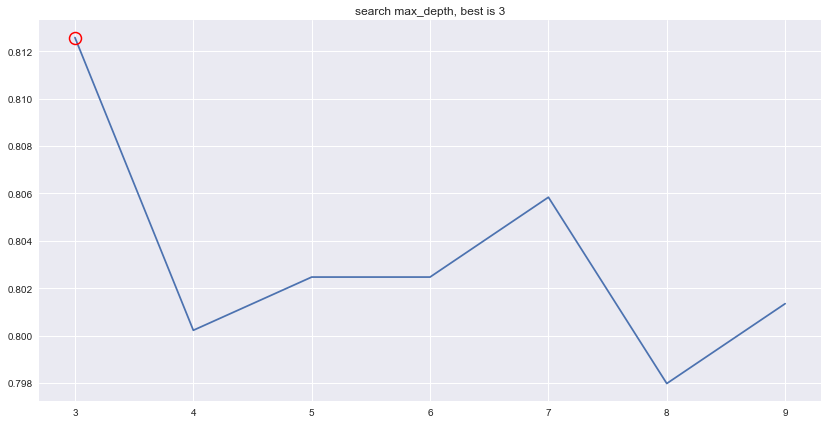

DecisionTreeClassifier score mean: 0.812580013619


In [38]:

# 决策树
titanic.estimator.decision_tree_classifier()
# grid seach寻找最优的决策树层数
best_score_, best_params_ = ABuMLGrid.grid_search_init_kwargs(titanic.estimator.clf, titanic.x, titanic.y,
                                                        param_name='max_depth',param_range=range(3, 10), show=True)

titanic.estimator.decision_tree_classifier(**best_params_)
titanic.cross_val_accuracy_score()


# 随机森林
titanic.estimator.random_forest_classifier()
# grid seach寻找最优的参数：n_estimators个体模型数量；max_features特征集子集样本比例；max_depth层数深度
param_grid = {
    'n_estimators': range(80, 150, 10),
    'max_features': np.arange(.5, 1.,.1).tolist(),
    'max_depth': list(range(1, 10)) + [None]
}
# n_jobs=-1开启多线程
# best_score_, best_params_ = ABuMLGrid.grid_search_mul_init_kwargs(titanic.estimator.clf, titanic.x, titanic.y,
#                                                                        param_grid=param_grid, show=True, n_jobs=-1)

# titanic.estimator.random_forest_classifier(**best_params_)
# titanic.cross_val_accuracy_score()

In [39]:
# GBDT
titanic.estimator.xgb_classifier()

# grid seach寻找最优的参数：n_estimators个体模型数量；max_depth层数深度
param_grid = {
    'n_estimators': range(80, 150, 10),
    'max_depth': range(1, 10)
}

# n_jobs=-1开启多线程
# best_score_, best_params_ = ABuMLGrid.grid_search_mul_init_kwargs(titanic.estimator.clf, titanic.x, titanic.y,
#                                                                        param_grid=param_grid, show=True, n_jobs=-1)


# titanic.estimator.xgb_classifier(**best_params_)
# titanic.cross_val_accuracy_score()

In [42]:
# Stacking
# 逻辑分类
titanic.estimator.logistic_classifier()
titanic.cross_val_accuracy_score()

# 随机森林
param = {'max_depth': 8, 'max_features': 0.6, 'n_estimators': 80}
titanic.estimator.random_forest_classifier(**param)
titanic.cross_val_accuracy_score()

# GBDT
param = {'max_depth': 5, 'n_estimators': 140}
titanic.estimator.xgb_classifier(**param)
titanic.cross_val_accuracy_score()

# 准备训练好的模型
titanic.estimator.logistic_classifier()
lr = titanic.fit()
param = {'max_depth': 8, 'max_features': 0.6, 'n_estimators': 80}
titanic.estimator.random_forest_classifier(**param)
rf = titanic.fit()
param = {'max_depth': 5, 'n_estimators': 140}
titanic.estimator.xgb_classifier(**param)
gbdt = titanic.fit()

# 构造stacking训练集，融合三个模型的预测的概率值作为特征数据
x_stk = np.array([lr.predict_proba(x)[:, 0], rf.predict_proba(x)[:, 0], gbdt.predict_proba(x)[:, 0]]).T
x_df_stk = pd.DataFrame(x_stk, columns=['lr', 'rf', 'gbdt'])
y_df = pd.DataFrame(y, columns=['y'])
df = y_df.join(x_df_stk)

# stacking模型
stackings = AbuML(x_stk, y, df)

stackings.estimator.logistic_classifier()

# 获得titanic的融合模型stk
stk = stackings.fit()

LogisticRegression score mean: 0.806974804222
RandomForestClassifier score mean: 0.831756894791
GradientBoostingClassifier score mean: 0.829421461809


In [43]:
from abupy import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

def lr_model(x_train, x_test, y_train, y_test):
    """返回训练好的逻辑分类模型及分数"""
    lr = LogisticRegression(C=1.0)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    return lr, metrics.accuracy_score(y_test, y_pred)

def rf_model(x_train, x_test, y_train, y_test):
    """返回训练好的随机森林模型及分数"""
    param_grid = {
    'n_estimators': range(80, 120, 10),
    'max_features': np.arange(.6, .9,.1).tolist(),
    'max_depth': list(range(3, 9)) + [None]
    }
    
    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)
    rf = RandomForestClassifier(**grid.best_params_)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    return rf, metrics.accuracy_score(y_test, y_pred)

def gbdt_model(x_train, x_test, y_train, y_test):
    """返回训练好的GBDT模型及分数"""
    param_grid = {
    'n_estimators': list(range(80, 120, 10)),
    'max_features': np.arange(.6, .9,.1).tolist(),
    'max_depth': list(range(3, 9)) + [None]
    }
    
    grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)
    gbdt = GradientBoostingClassifier(**grid.best_params_)
    gbdt.fit(x_train, y_train)
    y_pred = gbdt.predict(x_test)
    return gbdt, metrics.accuracy_score(y_test, y_pred)

def stack_models(x_train, x_test, y_train, y_test):
    """返回融合后的模型及分数"""
    param_grid = {
    'C': [.01, .1, 1, 10]
    }
    grid = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid.fit(x_train, y_train)
    stk = LogisticRegression(penalty='l1', tol=1e-6, **grid.best_params_)
    stk.fit(x_train, y_train)
    y_pred = stk.predict(x_test)
    return rf, metrics.accuracy_score(y_test, y_pred)

kf = KFold(len(titanic.y), n_folds=5, shuffle=True)
lr_scores = []
rf_scores = []
gbdt_scores = []
stk_scores = []

for train_index, test_index in kf:
    x_train, x_test = titanic.x[train_index], titanic.x[test_index]
    y_train, y_test = titanic.y[train_index], titanic.y[test_index]
    
    # 单个模型成绩
    lr, lr_score = lr_model(x_train, x_test, y_train, y_test)
    rf, rf_score = rf_model(x_train, x_test, y_train, y_test)
    gbdt, gbdt_score = gbdt_model(x_train, x_test, y_train, y_test)
    
    # stacking
    x_train_stk = np.array([lr.predict_proba(x_train)[:, 0], rf.predict_proba(x_train)[:, 0], gbdt.predict_proba(x_train)[:, 0]]).T
    x_test_stk = np.array([lr.predict_proba(x_test)[:, 0], rf.predict_proba(x_test)[:, 0], gbdt.predict_proba(x_test)[:, 0]]).T
    stk, stk_score = stack_models(x_train_stk, x_test_stk, y_train, y_test)
    
    # append score
    lr_scores.append(lr_score)
    rf_scores.append(rf_score)
    gbdt_scores.append(gbdt_score)
    stk_scores.append(stk_score)
    
print('lr mean score: {}'.format(np.mean(lr_scores)))
print('rf mean score: {}'.format(np.mean(rf_scores)))
print('gbdt mean score: {}'.format(np.mean(gbdt_scores)))
print('stk mean score: {}'.format(np.mean(stk_scores)))

print('lr std score: {}'.format(np.std(lr_scores)))
print('rf std score: {}'.format(np.std(rf_scores))) 
print('gbdt std score: {}'.format(np.std(gbdt_scores)))
print('stk std score: {}'.format(np.std(stk_scores)))

KeyboardInterrupt: 

In [ ]:
def three_kfolder(data, n_folds=5, shuffle=True, ratios=[4, 1, 2]):
    """按ratios数组随机(shuffle)三分割数据集，返回：traing_set, stacking_set, testing_set"""
    assert ratios and len(ratios) == 3, 'ratios必须是3-items-arraylike数组'
    data = np.array(data)
    N = len(data)
    ratios_nor = np.array(ratios).astype(float) / np.sum(ratios)
    ratios_num = (ratios_nor * N).astype(int).cumsum()

    for i in range(n_folds):
        ind = list(range(len(data)))
        np.random.shuffle(ind)
        data_shuf = data[ind]
        yield data_shuf[:ratios_num[0]], data_shuf[ratios_num[0]:ratios_num[1]], data_shuf[ratios_num[1]:ratios_num[2]]

# 使用demo   
data = ['a', 'c', 'd', 'e', 'g', '2','f', 'c','3', 'p']
for traing_set, stacking_set, testing_set in three_kfolder(data):
    print(traing_set)
    print(stacking_set)
    print(testing_set)